In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from scipy.stats import pearsonr, chi2_contingency, entropy
from scipy import special 
import seaborn as sns

In [2]:
df = pd.read_json('./data/data.json', lines=True)
labels = pd.read_csv('./data/labels.info', sep=',')

### Writing a function to harvest the data into a working dataframe

In [3]:
def get_dataframe(df):
    transcripts = df.columns
    dataframes = []
    for transcript in transcripts:
        df_curr_transcript = df.loc[:, transcript]
        df_curr_transcript.dropna(inplace=True)
        df_curr_transcript = list(df_curr_transcript)
        
        for position in df_curr_transcript:
            #position here is a dictionary
            for k1, v1, in position.items():
                order = list(v1.keys())[0]
                for k2, v2 in v1.items():
                    left_order = k2[:5]
                    centre_order = k2[1:6]
                    right_order = k2[len(k2)-5:]
                    
                    num_lists = len(v2)

                    left_dwelling_t = 0
                    left_sd = 0
                    left_mean = 0

                    centre_dwelling_t = 0
                    centre_sd = 0
                    centre_mean = 0
                    
                    right_dwelling_t = 0
                    right_sd = 0
                    right_mean = 0

                    for read in v2:
                        left_dwelling_t += read[0]
                        left_sd += read[1]
                        left_mean += read[2]

                        centre_dwelling_t += read[3]
                        centre_sd += read[4]
                        centre_mean += read[5]
                        
                        right_dwelling_t += read[6]
                        right_sd += read[7]
                        right_mean += read[8]

                    left_dwelling_t /= num_lists
                    left_sd /= num_lists
                    left_mean /= num_lists

                    centre_dwelling_t /= num_lists
                    centre_sd /= num_lists
                    centre_mean /= num_lists
                    
                    right_dwelling_t /= num_lists
                    right_sd /= num_lists
                    right_mean /= num_lists
                    

                curr_dataframe = pd.DataFrame({'transcript_id':[transcript], 'order': [order], 'curr_pos': [k1], 'left_order': [left_order], 'avg_left_dwelling_t': [left_dwelling_t], 'avg_left_sd': [left_sd], 
                                            'avg_left_mean': [left_mean], 'centre_order': [centre_order], 'avg_centre_dwelling_t': [centre_dwelling_t], 'avg_centre_sd': [centre_sd], 'avg_centre_mean': [centre_mean], 
                                            'right_order': [right_order], 'avg_right_dwelling_t': [right_dwelling_t], 'avg_right_sd': [right_sd], 'avg_right_mean': [right_mean]})   
                dataframes.append(curr_dataframe)
    final_df = pd.concat(dataframes)
    final_df['curr_pos'] = final_df['curr_pos'].astype('int64')
    return final_df 

In [4]:
df1 = get_dataframe(df)

### Play with df1

### Encoding

In [5]:
df1 = pd.merge(df1, labels, how='left',left_on=['transcript_id', 'curr_pos'], right_on=['transcript_id', 'transcript_position'])
df1 = df1.drop(['transcript_position'], axis='columns')

In [6]:
df2 = df1.copy()
df2['left_1'] = df2['left_order'].apply(lambda x: x[0])
df2['left_2'] = df2['left_order'].apply(lambda x: x[1])
df2['left_3'] = df2['left_order'].apply(lambda x: x[2])
df2['left_4'] = df2['left_order'].apply(lambda x: x[3])
df2['left_5'] = df2['left_order'].apply(lambda x: x[4])

df2['centre_1'] = df2['centre_order'].apply(lambda x: x[0])
df2['centre_2'] = df2['centre_order'].apply(lambda x: x[1])
df2['centre_3'] = df2['centre_order'].apply(lambda x: x[2])
df2['centre_4'] = df2['centre_order'].apply(lambda x: x[3])
df2['centre_5'] = df2['centre_order'].apply(lambda x: x[4])

df2['right_1'] = df2['right_order'].apply(lambda x: x[0])
df2['right_2'] = df2['right_order'].apply(lambda x: x[1])
df2['right_3'] = df2['right_order'].apply(lambda x: x[2])
df2['right_4'] = df2['right_order'].apply(lambda x: x[3])
df2['right_5'] = df2['right_order'].apply(lambda x: x[4])

In [7]:
df2

,transcript_id,order,curr_pos,left_order,avg_left_dwelling_t,avg_left_sd,avg_left_mean,centre_order,avg_centre_dwelling_t,avg_centre_sd,...,centre_1,centre_2,centre_3,centre_4,centre_5,right_1,right_2,right_3,right_4,right_5
0,ENST00000000233,AAGACCA,244,AAGAC,0.008264,4.223784,123.702703,AGACC,0.009373,7.382162,...,A,G,A,C,C,G,A,C,C,A
1,ENST00000000233,CAAACTG,261,CAAAC,0.006609,3.216424,109.681395,AAACT,0.006813,3.226535,...,A,A,A,C,T,A,A,C,T,G
2,ENST00000000233,GAAACAG,316,GAAAC,0.007570,2.940541,105.475676,AAACA,0.007416,3.642703,...,A,A,A,C,A,A,A,C,A,G
3,ENST00000000233,AGAACAT,332,AGAAC,0.010620,6.476350,129.355000,GAACA,0.008632,2.899200,...,G,A,A,C,A,A,A,C,A,T
4,ENST00000000233,AGGACAA,368,AGGAC,0.010701,6.415051,117.924242,GGACA,0.011479,5.870303,...,G,G,A,C,A,G,A,C,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,GGGACAT,1348,GGGAC,0.009594,3.294164,118.232877,GGACA,0.007300,4.929726,...,G,G,A,C,A,G,A,C,A,T
121834,ENST00000641834,CTGACAC,1429,CTGAC,0.008393,4.511014,110.969565,TGACA,0.010305,9.105797,...,T,G,A,C,A,G,A,C,A,C
121835,ENST00000641834,TGGACAC,1531,TGGAC,0.008161,3.918438,113.968750,GGACA,0.006877,4.759687,...,G,G,A,C,A,G,A,C,A,C
121836,ENST00000641834,CTGACCA,1537,CTGAC,0.008044,3.191228,109.354386,TGACC,0.007419,6.552982,...,T,G,A,C,C,G,A,C,C,A


In [8]:
df2.columns

Index(['transcript_id', 'order', 'curr_pos', 'left_order',
       'avg_left_dwelling_t', 'avg_left_sd', 'avg_left_mean', 'centre_order',
       'avg_centre_dwelling_t', 'avg_centre_sd', 'avg_centre_mean',
       'right_order', 'avg_right_dwelling_t', 'avg_right_sd', 'avg_right_mean',
       'gene_id', 'label', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5',
       'centre_1', 'centre_2', 'centre_3', 'centre_4', 'centre_5', 'right_1',
       'right_2', 'right_3', 'right_4', 'right_5'],
      dtype='object')

In [9]:
df2.loc[:, ['left_order', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5']]

,left_order,left_1,left_2,left_3,left_4,left_5
0,AAGAC,A,A,G,A,C
1,CAAAC,C,A,A,A,C
2,GAAAC,G,A,A,A,C
3,AGAAC,A,G,A,A,C
4,AGGAC,A,G,G,A,C
...,...,...,...,...,...,...
121833,GGGAC,G,G,G,A,C
121834,CTGAC,C,T,G,A,C
121835,TGGAC,T,G,G,A,C
121836,CTGAC,C,T,G,A,C


In [10]:
#categorical data
categorical_cols = ['left_1', 'left_2', 'left_3', 'left_4', 'left_5',
       'centre_1', 'centre_2', 'centre_3', 'centre_4', 'centre_5', 'right_1',
       'right_2', 'right_3', 'right_4', 'right_5']

#import pandas as pd
df3 = pd.get_dummies(df2, columns = categorical_cols)

Now, there could be a case where the letters A,C,G,T is not found in the column and could be found in the unknown test set. So we need to introduce that column. 

In [11]:
expected_columns = ['left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
                    'left_2_A', 'left_2_C', 'left_2_G', 'left_2_T', 
                    'left_3_A', 'left_3_C', 'left_3_G', 'left_3_T', 
                    'left_4_A', 'left_4_C', 'left_4_G', 'left_4_T', 
                    'left_5_A', 'left_5_C', 'left_5_G', 'left_5_T',
                    'centre_1_A', 'centre_1_C', 'centre_1_G', 'centre_1_T', 
                    'centre_2_A', 'centre_2_C', 'centre_2_G', 'centre_2_T', 
                    'centre_3_A', 'centre_3_C', 'centre_3_G', 'centre_3_T', 
                    'centre_4_A', 'centre_4_C', 'centre_4_G', 'centre_4_T', 
                    'centre_5_A', 'centre_5_C', 'centre_5_G', 'centre_5_T',
                    'right_1_A', 'right_1_C', 'right_1_G', 'right_1_T', 
                    'right_2_A', 'right_2_C', 'right_2_G', 'right_2_T', 
                    'right_3_A', 'right_3_C', 'right_3_G', 'right_3_T',  
                    'right_4_A', 'right_4_C', 'right_4_G', 'right_4_T', 
                    'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T']

In [12]:
added_cols = []
df3_cols = df3.columns
for col in expected_columns:
    if col not in df3_cols:
        df3[col] = [0 for i in range(len(df3))]
        added_cols.append(col)

In [13]:
added_cols

['left_2_C',
 'left_3_C',
 'left_3_T',
 'left_4_C',
 'left_4_G',
 'left_4_T',
 'left_5_A',
 'left_5_G',
 'left_5_T',
 'centre_1_C',
 'centre_2_C',
 'centre_2_T',
 'centre_3_C',
 'centre_3_G',
 'centre_3_T',
 'centre_4_A',
 'centre_4_G',
 'centre_4_T',
 'centre_5_G',
 'right_1_C',
 'right_1_T',
 'right_2_C',
 'right_2_G',
 'right_2_T',
 'right_3_A',
 'right_3_G',
 'right_3_T',
 'right_4_G']

In [14]:
ordered_columns = ['transcript_id', 'order', 'curr_pos', 'left_order',
       'avg_left_dwelling_t', 'avg_left_sd', 'avg_left_mean', 'centre_order',
       'avg_centre_dwelling_t', 'avg_centre_sd', 'avg_centre_mean',
       'right_order', 'avg_right_dwelling_t', 'avg_right_sd', 'avg_right_mean',
       'gene_id', 'left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
                    'left_2_A', 'left_2_C', 'left_2_G', 'left_2_T', 
                    'left_3_A', 'left_3_C', 'left_3_G', 'left_3_T', 
                    'left_4_A', 'left_4_C', 'left_4_G', 'left_4_T', 
                    'left_5_A', 'left_5_C', 'left_5_G', 'left_5_T',
                    'centre_1_A', 'centre_1_C', 'centre_1_G', 'centre_1_T', 
                    'centre_2_A', 'centre_2_C', 'centre_2_G', 'centre_2_T', 
                    'centre_3_A', 'centre_3_C', 'centre_3_G', 'centre_3_T', 
                    'centre_4_A', 'centre_4_C', 'centre_4_G', 'centre_4_T', 
                    'centre_5_A', 'centre_5_C', 'centre_5_G', 'centre_5_T',
                    'right_1_A', 'right_1_C', 'right_1_G', 'right_1_T', 
                    'right_2_A', 'right_2_C', 'right_2_G', 'right_2_T', 
                    'right_3_A', 'right_3_C', 'right_3_G', 'right_3_T',  
                    'right_4_A', 'right_4_C', 'right_4_G', 'right_4_T', 
                    'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T', 'label']
df3 = df3[ordered_columns]
    

In [20]:
df4 = df3.drop(['transcript_id', 'order', 'left_order', 'centre_order', 'right_order', 'gene_id'], axis=1)

### EDA

In [30]:
cat_lst = ['left_1_A',
       'left_1_C', 'left_1_G', 'left_1_T', 'left_2_A', 'left_2_C', 'left_2_G',
       'left_2_T', 'left_3_A', 'left_3_C', 'left_3_G', 'left_3_T', 'left_4_A',
       'left_4_C', 'left_4_G', 'left_4_T', 'left_5_A', 'left_5_C', 'left_5_G',
       'left_5_T', 'centre_1_A', 'centre_1_C', 'centre_1_G', 'centre_1_T',
       'centre_2_A', 'centre_2_C', 'centre_2_G', 'centre_2_T', 'centre_3_A',
       'centre_3_C', 'centre_3_G', 'centre_3_T', 'centre_4_A', 'centre_4_C',
       'centre_4_G', 'centre_4_T', 'centre_5_A', 'centre_5_C', 'centre_5_G',
       'centre_5_T', 'right_1_A', 'right_1_C', 'right_1_G', 'right_1_T',
       'right_2_A', 'right_2_C', 'right_2_G', 'right_2_T', 'right_3_A',
       'right_3_C', 'right_3_G', 'right_3_T', 'right_4_A', 'right_4_C',
       'right_4_G', 'right_4_T', 'right_5_A', 'right_5_C', 'right_5_G',
       'right_5_T', 'label']
for val in added_cols:
    cat_lst.remove(val)

In [31]:
cat_dict = {}
cont_dict = {}
# cat_lst = ['left_1_A',
#        'left_1_C', 'left_1_G', 'left_1_T', 'left_2_A', 'left_2_C', 'left_2_G',
#        'left_2_T', 'left_3_A', 'left_3_C', 'left_3_G', 'left_3_T', 'left_4_A',
#        'left_4_C', 'left_4_G', 'left_4_T', 'left_5_A', 'left_5_C', 'left_5_G',
#        'left_5_T', 'centre_1_A', 'centre_1_C', 'centre_1_G', 'centre_1_T',
#        'centre_2_A', 'centre_2_C', 'centre_2_G', 'centre_2_T', 'centre_3_A',
#        'centre_3_C', 'centre_3_G', 'centre_3_T', 'centre_4_A', 'centre_4_C',
#        'centre_4_G', 'centre_4_T', 'centre_5_A', 'centre_5_C', 'centre_5_G',
#        'centre_5_T', 'right_1_A', 'right_1_C', 'right_1_G', 'right_1_T',
#        'right_2_A', 'right_2_C', 'right_2_G', 'right_2_T', 'right_3_A',
#        'right_3_C', 'right_3_G', 'right_3_T', 'right_4_A', 'right_4_C',
#        'right_4_G', 'right_4_T', 'right_5_A', 'right_5_C', 'right_5_G',
#        'right_5_T', 'label']
cont_lst = ['curr_pos', 'avg_left_dwelling_t', 'avg_left_sd', 'avg_left_mean',
       'avg_centre_dwelling_t', 'avg_centre_sd', 'avg_centre_mean',
       'avg_right_dwelling_t', 'avg_right_sd', 'avg_right_mean'
]

for val in cat_lst:
    cat_dict[val] = 'categorical'

for val in cont_lst:
       cont_dict[val] = 'continuous'

In [32]:
cont_dict.update(cat_dict)

In [33]:
df4[cat_lst] = df4[cat_lst].astype('category')

C:\Users\xyber\AppData\Local\Temp\ipykernel_24684\845842625.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\xyber\AppData\Local\Temp\ipykernel_24684\845842625.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\xyber\AppData\Local\Temp\ipykernel_24684\845842625.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\xyber\AppData\Local\Temp\ipykernel_24684\845842625.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\xyber\AppData\Local\Temp\ipykernel_24684\845842625.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
C:\Users\xyber\AppData\Local\Temp\ipykernel_24684\845842625.py:17: RuntimeWarning: in

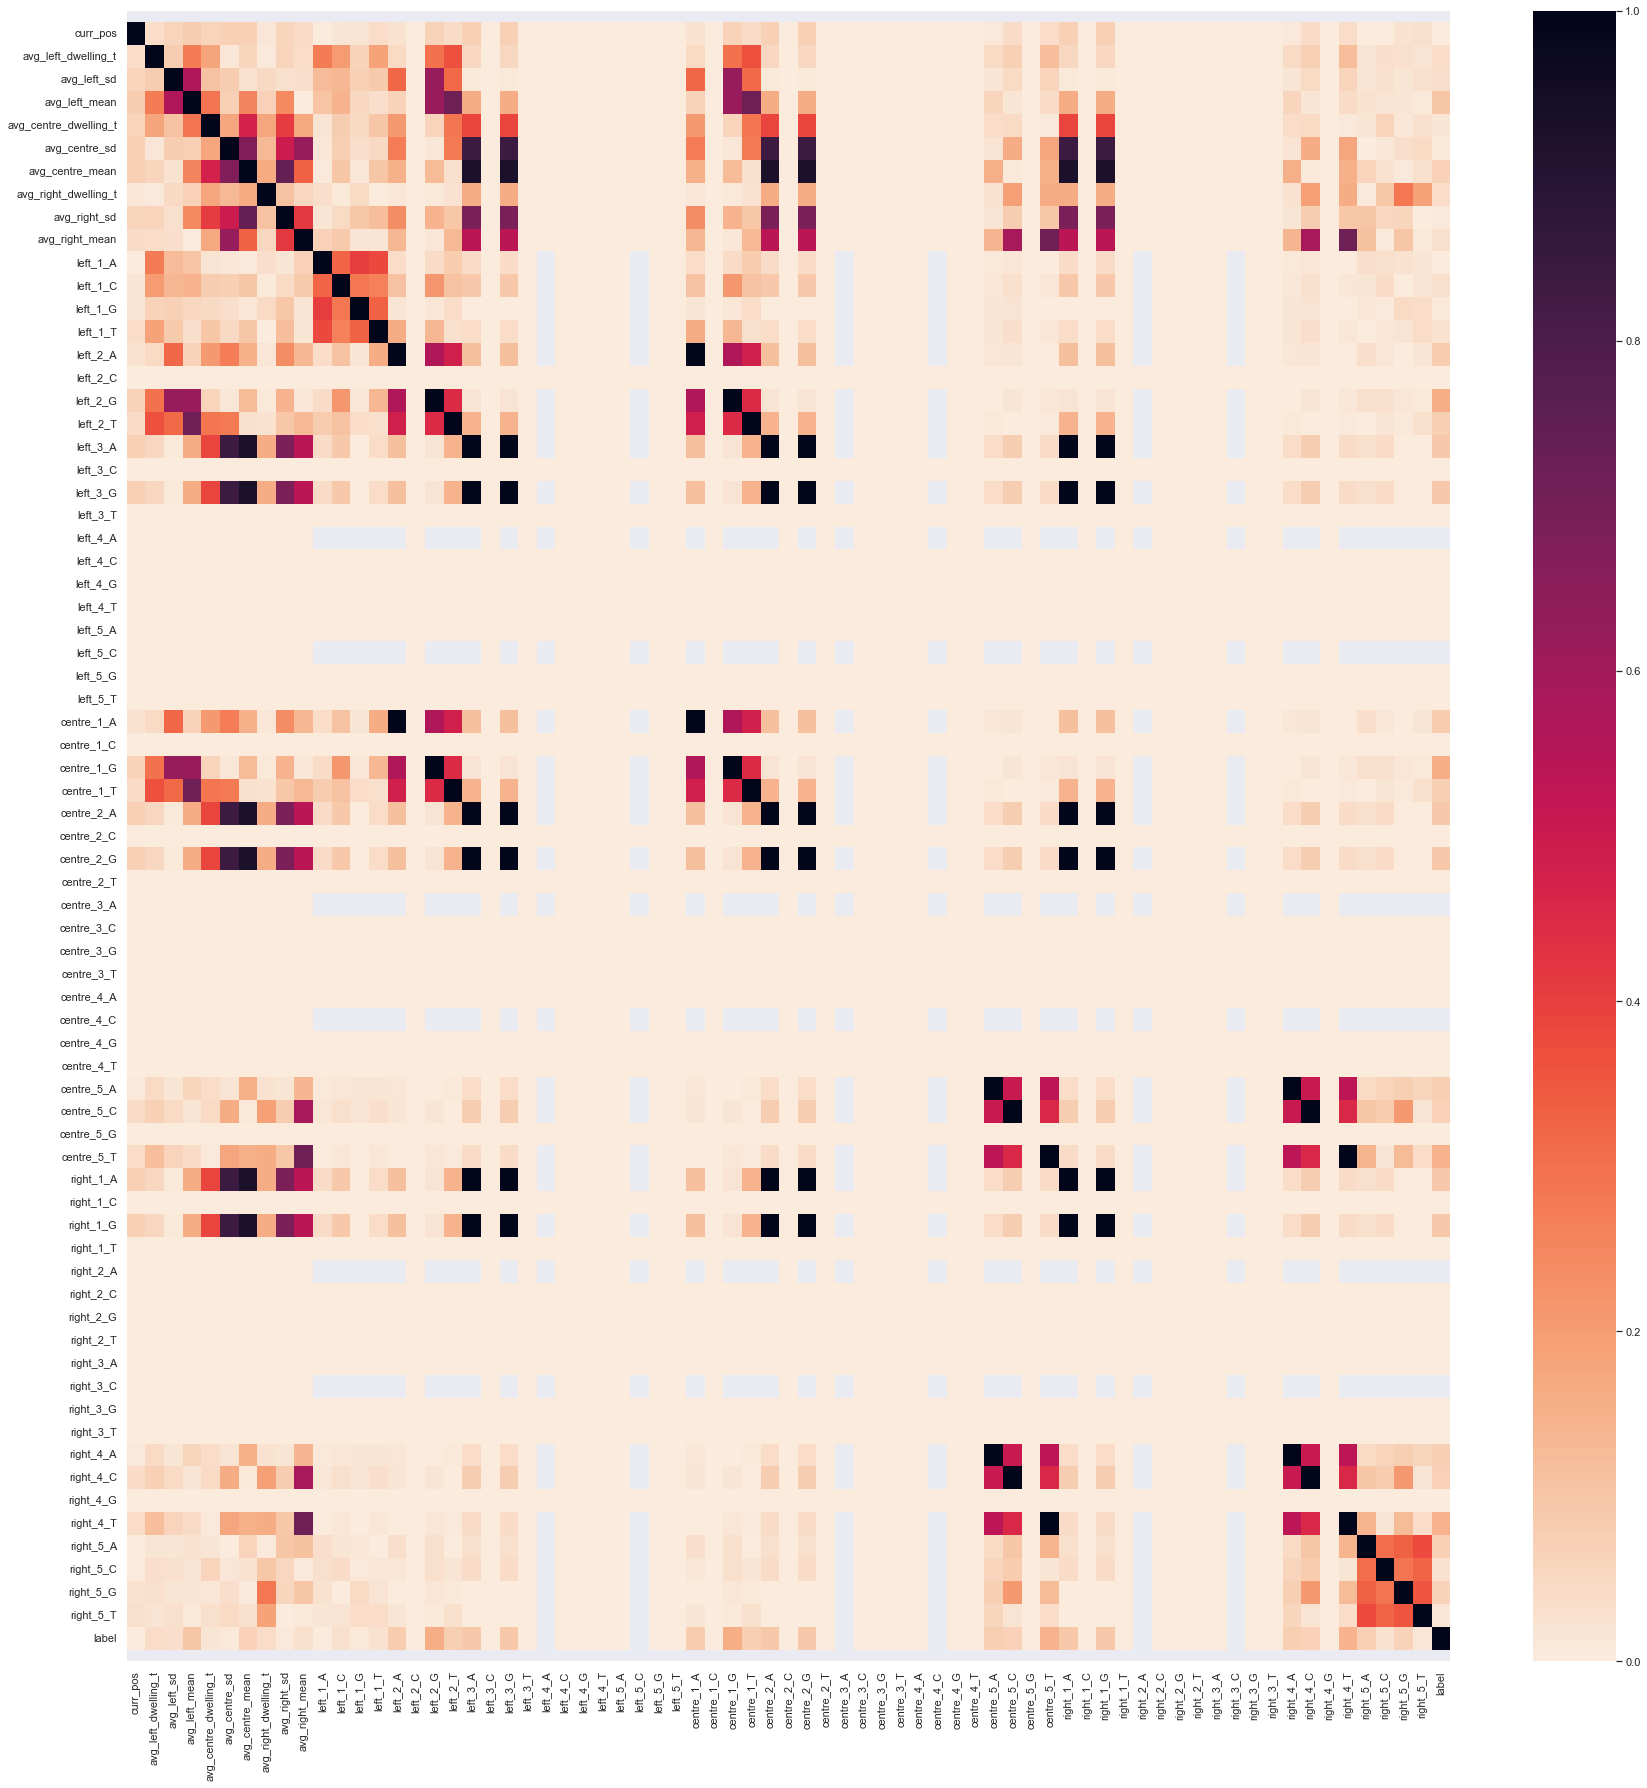

In [36]:
column_names = df4.columns.tolist()
corr_dict = cont_dict
corr_lst = []

corr_matrix = np.zeros((len(column_names), len(column_names)))
corr_matrix = pd.DataFrame(corr_matrix, columns = column_names, index = column_names)

def cramers_corrected_stat(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def correlation_coeff(x, y):
    abs_corr = abs(x.corr(y, method = 'pearson'))
    return abs_corr

for key in corr_dict:
    for key2 in corr_dict:
        if corr_dict[key] == 'continuous' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_coeff(df4[key], df4[key2])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_ratio(df4[key], df4[key2])
        elif corr_dict[key] == 'continuous' and corr_dict[key2] == 'categorical':
            curr_corr = correlation_ratio(df4[key2], df4[key])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'categorical':
            curr_corr = cramers_corrected_stat(df4[key], df4[key2])
        corr_matrix[key][key2] = curr_corr

        if curr_corr >= 0.7 and column_names.index(key) < column_names.index(key2):
            corr_lst.append([key, key2, curr_corr])
            #print(key + "," + key2 + " " + str(curr_corr))

sns.set(rc={'figure.figsize':(25,25)})
ax = sns.heatmap(corr_matrix,
                 xticklabels = column_names,
                 yticklabels = column_names,
                 vmin = 0,
                 vmax = 1,
                 cmap = sns.cm.rocket_r)

top, bottom = ax.get_ylim()
ax.set_ylim(top + 0.5, bottom - 0.5)
plt.tight_layout()
plt.show()

In [37]:
corr_lst

[['avg_left_mean', 'left_2_T', 0.7226337965291221],
 ['avg_left_mean', 'centre_1_T', 0.7226337965291221],
 ['avg_centre_sd', 'left_3_A', 0.8390524759136291],
 ['avg_centre_sd', 'left_3_G', 0.8390524759136291],
 ['avg_centre_sd', 'centre_2_A', 0.8390524759136291],
 ['avg_centre_sd', 'centre_2_G', 0.8390524759136291],
 ['avg_centre_sd', 'right_1_A', 0.8390524759136291],
 ['avg_centre_sd', 'right_1_G', 0.8390524759136291],
 ['avg_centre_mean', 'avg_right_sd', 0.7388035968604605],
 ['avg_centre_mean', 'left_3_A', 0.9290759084647923],
 ['avg_centre_mean', 'left_3_G', 0.9290759084647923],
 ['avg_centre_mean', 'centre_2_A', 0.9290759084647923],
 ['avg_centre_mean', 'centre_2_G', 0.9290759084647923],
 ['avg_centre_mean', 'right_1_A', 0.9290759084647923],
 ['avg_centre_mean', 'right_1_G', 0.9290759084647923],
 ['avg_right_mean', 'centre_5_T', 0.7215928898348263],
 ['avg_right_mean', 'right_4_T', 0.7215928898348263],
 ['left_2_A', 'centre_1_A', 0.9999825173142242],
 ['left_2_G', 'centre_1_G', 0.

### Train test split

In [ ]:
labels

In [ ]:
labels.label.value_counts()[0]/labels.label.value_counts()[1]

There are 21 times more zeroes than 1's. 

In [ ]:
genes = list(labels['gene_id'].unique())

In [ ]:
train_genes, test_genes = train_test_split(genes, train_size = 0.8, random_state=42)

In [ ]:
train_labels = labels[labels['gene_id'].isin(train_genes)]
test_labels = labels[labels['gene_id'].isin(test_genes)]

In [ ]:
train_labels.label.value_counts()[0]/train_labels.label.value_counts()[1]

In [ ]:
test_labels.label.value_counts()[0]/test_labels.label.value_counts()[1]

Wow the imbalance in the split is still present and is roughly the same in both train and test and original. Nice.

In [ ]:
train_labels

In [ ]:
X_train = pd.merge(train_labels, df3, how='inner',left_on=['gene_id', 'transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])
X_test = pd.merge(test_labels, df3, how='inner',left_on=['gene_id','transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])

In [ ]:
y_train = np.asarray(X_train['label'])
y_test = np.asarray(X_test['label'])

In [ ]:
X_train = X_train.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order', 'left_order', 'centre_order', 'right_order'], axis=1)
X_test = X_test.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order', 'left_order', 'centre_order', 'right_order'], axis=1)

In [ ]:
X_train

### Hi ppl, yall can use the code till here. Below can be done in many ways and feel free to do ur own way. 

### We first try to handle the imbalance by not doing anything. We train the model with the imabalanced class and see if it can pick up on the imbalance naturally. 

First, let us get a baseline score.

In [ ]:
scaler= MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
# instantiate the classifier 
xgb_clf = XGBClassifier()
rf_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier(max_iter=1000)
dt_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression()


# fit the classifier to the training data
xgb_clf.fit(scaled_X_train, y_train)
rf_clf.fit(scaled_X_train, y_train)
lgbm_clf.fit(scaled_X_train, y_train)
dt_clf.fit(scaled_X_train, y_train)
lr_clf.fit(scaled_X_train, y_train)

In [ ]:
# make predictions on train data
xgb_y_pred_training = xgb_clf.predict(scaled_X_train)
print(f"Base line xgb Training Precision Score: {precision_score(y_train, xgb_y_pred_training)}")

# make predictions on train data
rf_y_pred_training = rf_clf.predict(scaled_X_train)
print(f"Base line rf Training Precision Score: {precision_score(y_train, rf_y_pred_training)}")

# make predictions on train data
lgbm_y_pred_training = lgbm_clf.predict(scaled_X_train)
print(f"Base line lgbm Training Precision Score: {precision_score(y_train, lgbm_y_pred_training)}")

# make predictions on train data
dt_y_pred_training = dt_clf.predict(scaled_X_train)
print(f"Base line dt Training Precision Score: {precision_score(y_train, dt_y_pred_training)}")



In [ ]:
# make predictions on test data
xgb_y_pred = xgb_clf.predict(scaled_X_test)
xgb_y_prob = xgb_clf.predict_proba(scaled_X_test)[:, 1]

rf_y_pred = rf_clf.predict(scaled_X_test)
rf_y_prob = rf_clf.predict_proba(scaled_X_test)[:, 1]

lgbm_y_pred = lgbm_clf.predict(scaled_X_test)
lgbm_y_prob = lgbm_clf.predict_proba(scaled_X_test)[:, 1]

dt_y_pred = dt_clf.predict(scaled_X_test)
dt_y_prob = dt_clf.predict_proba(scaled_X_test)[:, 1]

lr_y_pred = lr_clf.predict(scaled_X_test)
lr_y_prob = lr_clf.predict_proba(scaled_X_test)[:, 1]


In [ ]:
print(f"Base line xgb Accuracy Score: {accuracy_score(y_test, xgb_y_pred)}")
print(f"Base line xgb Precision Score: {precision_score(y_test, xgb_y_pred)}")
print(f"Base line xgb Recall Score: {recall_score(y_test, xgb_y_pred)}")
print(f"Base line xgb AUCROC Score: {roc_auc_score(y_test, xgb_y_prob)}")

In [ ]:
print(f"Base line rf Accuracy Score: {accuracy_score(y_test, rf_y_pred)}")
print(f"Base line rf Precision Score: {precision_score(y_test, rf_y_pred)}")
print(f"Base line rf Recall Score: {recall_score(y_test, rf_y_pred)}")
print(f"Base line rf AUCROC Score: {roc_auc_score(y_test, rf_y_prob)}")

In [ ]:
print(f"Base line lgbm Accuracy Score: {accuracy_score(y_test, lgbm_y_pred)}")
print(f"Base line lgbm Precision Score: {precision_score(y_test, lgbm_y_pred)}")
print(f"Base line lgbm Recall Score: {recall_score(y_test, lgbm_y_pred)}")
print(f"Base line lgbm AUCROC Score: {roc_auc_score(y_test, lgbm_y_prob)}")

In [ ]:
print(f"Base line dt Accuracy Score: {accuracy_score(y_test, dt_y_pred)}")
print(f"Base line dt Precision Score: {precision_score(y_test, dt_y_pred)}")
print(f"Base line dt Recall Score: {recall_score(y_test, dt_y_pred)}")
print(f"Base line dt AUCROC Score: {roc_auc_score(y_test, dt_y_prob)}")

In [ ]:
print(f"Base line lr Accuracy Score: {accuracy_score(y_test, lr_y_pred)}")
print(f"Base line lr Precision Score: {precision_score(y_test, lr_y_pred)}")
print(f"Base line lr Recall Score: {recall_score(y_test, lr_y_pred)}")
print(f"Base line lr AUCROC Score: {roc_auc_score(y_test, lr_y_prob)}")

In [ ]:
base_results = [['xgb', accuracy_score(y_test, xgb_y_pred), precision_score(y_test, xgb_y_pred), recall_score(y_test, xgb_y_pred), roc_auc_score(y_test, xgb_y_prob)], 
                ['rf', accuracy_score(y_test, rf_y_pred), precision_score(y_test, rf_y_pred), recall_score(y_test, rf_y_pred), roc_auc_score(y_test, rf_y_prob)], 
                ['lgbm', accuracy_score(y_test, lgbm_y_pred), precision_score(y_test, lgbm_y_pred), recall_score(y_test, lgbm_y_pred), roc_auc_score(y_test, lgbm_y_prob)], 
                ['dt', accuracy_score(y_test, dt_y_pred), precision_score(y_test, dt_y_pred), recall_score(y_test, dt_y_pred), roc_auc_score(y_test, dt_y_prob)],
                ['lr', accuracy_score(y_test, lr_y_pred), precision_score(y_test, lr_y_pred), recall_score(y_test, lr_y_pred), roc_auc_score(y_test, lr_y_prob)]]
base_results_df = pd.DataFrame(base_results, columns=['model', 'accuracy', 'precision', 'recall', 'rocauc'])

In [ ]:
base_results_df = base_results_df.set_index(['model'])
base_results_df.plot(kind='bar', figsize=(10,10))


So the model's are obviously overfitting and can't pick up on the intricacised of the 1 label.

Now that we have our baseline score, we shall focus on hypertuning. First, we do so with Cross Validation. Let us create the functions first to make our lives easier. 

In [ ]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [ ]:
# For a model, we perform cross validation. The thing we will be changing are the hyperparameters for this model. 
def perform_cv(model, X, y):
    scoring = ['precision', 'recall', 'roc_auc', 'accuracy']
    scores = cross_validate(model, X, y, scoring=scoring)
    precision = np.mean(scores['test_precision'])
    recall = np.mean(scores['test_recall'])
    rocauc = np.mean(scores['test_roc_auc'])
    accuracy = np.mean(scores['test_accuracy'])
    results = [precision, recall, rocauc, accuracy]
    return results

def get_scores(final_model, X_test, y_test):
    y_pred = final_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    rocauc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cm = ConfusionMatrixDisplay(cm)
    results = {'Precision': precision, 'Recall': recall, 'rocauc': rocauc, 'accuracy': accuracy}
    return results, cm
    

In [ ]:
perform_cv(xgb_clf, scaled_X_train, y_train)

In [ ]:
results, cm = get_scores(xgb_clf, scaled_X_test, y_test)

In [ ]:
cm.plot()

Now let us create some frameworks for hypertuning. We can create one with gridsearchcv, randomsearchcv, and manual input of hyperparameters.

### Randomized Search CV

In [ ]:
xgb_params = {
    'eta': [0, 0.0001, 0.001, 0.01, 0.1, 1], #smaller learning rate -> overfit
    'gamma': np.linspace(0, 100, 10), 
    'max_depth': np.arange(0, 15), 
     'subsample': [0.5], 
     'alpha': np.linspace(0, 20, 50), 
     'scale_pos_weight': [21]
}

In [ ]:
xgb_rcv = RandomizedSearchCV(xgb_clf, xgb_params, n_iter=10, scoring=['precision', 'recall', 'roc_auc', 'accuracy'], refit='precision', n_jobs=-1, cv=5)

In [ ]:
search_xgb = xgb_rcv.fit(X_train, y_train)

In [ ]:
search_results = pd.DataFrame(search_xgb.cv_results_)

In [ ]:
search_results.columns

In [ ]:
search_results[['param_subsample', 'param_scale_pos_weight', 'param_max_depth',
       'param_gamma', 'param_eta', 'param_alpha', 'params',
        'mean_test_precision',
       'rank_test_precision',
       'mean_test_recall', 'rank_test_recall']]

In [ ]:
hypertuned_xgb_params = dict(search_results[search_results.rank_test_recall==1]['params'])[2]
xgb_tuned = XGBClassifier(hypertuned_xgb_params)

### Split training set into train and validation

In [ ]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
### Check whether the split gave a good imbalance
dic = defaultdict(lambda: 0)
for value in y_valid:
    dic[value] += 1
print(dic[0]/dic[1])

dic = defaultdict(lambda: 0)
for value in y_training:
    dic[value] += 1
print(dic[0]/dic[1])


Let us perform smote on the training data. 

In [ ]:
oversample = SMOTE(random_state=42)
X_training_smote, y_training_smote = oversample.fit_resample(X_training, y_training)

Let us now scale the training smote data and validation data

In [ ]:
scaler_training = MinMaxScaler()
scaled_X_training_smote = scaler_training.fit_transform(X_training_smote)
scaled_X_validation = scaler_training.transform(X_valid)

We now have the following datasets to train and validate with:
- X_train: scaled_X_training_smote
- y_train: y_training_smote
- X_valid: scaled_X_validation
- y_valid: y_valid

### Modelling

In [ ]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = ['auc', 'precision']
eval_set = [(scaled_X_training_smote, y_training_smote), (scaled_X_validation, y_valid)]
xgb_clf = XGBClassifier()
xgb_clf.fit(scaled_X_training_smote, y_training_smote, eval_metric=['error', 'logloss'], eval_set=eval_set, verbose=True)
y_pred = xgb_clf.predict(scaled_X_validation)


accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
probs = xgb_clf.predict_proba(scaled_X_validation)[:, 1]
rocauc = roc_auc_score(y_valid, probs)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("ROCAUC: %.2f%%" % (rocauc * 100.0))

In [ ]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Valid')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

### Scale the data

In [ ]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Note that we do not need to specify the categorical columns when scaling because it won't change it's values

In [ ]:
dic = defaultdict(lambda: 0)
for value in y_train:
    dic[value] += 1
print(dic[0]/dic[1])
